<h2>Imports</h2>

In [1]:
import math
import random
import os
from common.multiprocessing_env import SubprocVecEnv
from ppo import *
import datetime
import fnmatch

import gym
import my_envs
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(0)
torch.manual_seed(2)

%matplotlib inline

# Load baseline policies
Load trained baseline policies on individually modified environments for testing on multi-modified environment
### Environments:

#### InvertedPendulum-v2 environment:  
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant environment:
<img src="./notebookImages/ant.png" width="300">

<h2>Use CUDA</h2>

In [2]:
use_cuda = torch.cuda.is_available()
#use_cuda = False
device   = torch.device("cuda" if use_cuda else "cpu")

## Helper Functions

In [3]:
def make_env(env_name):
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk

In [145]:
class baseline_ensemble():
    def __init__(self, base_env_name, import_tags, num_inputs, num_outputs, debug = False):
        self.base_env_name = base_env_name
        self.import_tags = import_tags
        self.import_folders = {} 
        self.policies = {}
        self.policy_list = []
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.debug = debug
        
    def import_policies(self):
        folder_names = os.listdir('./baseline_weights')
        for mod in self.import_tags:
            self.import_folders[mod] = fnmatch.filter(folder_names, self.base_env_name + mod + '*')
        
        for key, val in self.import_folders.items():
            folder = os.listdir('./baseline_weights/' + str(val[0]))
            
            if self.debug:
                print("weight folder:     ", folder)
            
            weight_file = fnmatch.filter(folder, '*endweights')
            weight_file = weight_file[0]
            
            if self.debug:
                print("Weight file:     ", weight_file)
            
            self.policies[key] = PPO(self.num_inputs, self.num_outputs)
            full_weight_file = './baseline_weights/' + str(val[0]) + '/' + weight_file
            self.policies[key].load_weights(full_weight_file)
            
        if self.debug:
            print("Imported Policies:\n")
            for mod, policy in self.policies.items():
                print("Modification:    ", mod)
                print(policy.model)
                
        self.policy_list = self.policies.values()
        
    def uniform_action(self, state):
        """ Outputs a uniform average of actions from variable number of policies"""
        num_policies = len(self.policy_list)
        actions = np.array([policy.model.sample_action(state) for policy in self.policy_list])

        action = action.sum()/num_policies
        return action

    def weighted_action(self, state, policy_weights):
        """ Outputs a weighted sum of actions defined by weight vector and variable number of policies"""
        if policy_weights.shape[1] != len(self.policy_list):
            print("Weight vector length must match number of policies\n")
            print("weights:    ", policy_weights)
            print("length ", policy_weights.shape[1])
            print("policy list:    ", self.policy_list)
            print("length: ", len(self.policy_list))
            return 
        
        if self.debug:
            print("weights:    ", policy_weights)
            print("length ", policy_weights.shape[1])
            print("policy list:    ", self.policy_list)
            print("length: ", len(self.policy_list))

        for i, policy in enumerate(self.policy_list):
            if i == 0:
                actions = policy.model.sample_action(state)
            else:
                actions = torch.cat((actions, policy.model.sample_action(state)), 2)
            
        actions = actions.squeeze(0)
        weights = policy_weights

        if self.debug:
            print("multi-policy multi-env action tensor: ")
            print(actions, actions.size())
            print("ensemble weights:")
            print(weights, weights.size())
        
        action = torch.sum((actions * weights), dim=1).unsqueeze(1)
        if self.debug:
            print("action:")
            print(action, action.size())
        return action
    
    
class PPO_Ensemble(PPO):
    def __init__(self, num_inputs, num_outputs, ensemble, hidden_size=64, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950):
        super().__init__(num_inputs, num_outputs, hidden_size=64, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950)
        self.ensemble = ensemble
        
    def collect_data(self, envs):
        if self.state is None:
            state = envs.reset()
            
        #----------------------------------
        #collect data
        #----------------------------------
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0
        counter = 0

        for _ in range(self.num_steps):
            state = torch.FloatTensor(state).to(device)
            dist, value = self.model(state)

            weights = dist.sample()
            action = self.ensemble.weighted_action(state.cpu().numpy(), weights)
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
#             next_state, reward, done, _ = envs.step(action)
            
            log_prob = dist.log_prob(weights)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(weights)

            state = next_state
            self.frame_idx += 1


        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = self.model(next_state)

        return log_probs, values, states, actions, rewards, masks, next_value
        
class ensemble_testing_envs(testing_envs):
    def __init__(self, env_names, VISUALIZE, COMPENSATION, results_dir, train_env_index, logging_interval = 10):
        super().__init__(env_names, VISUALIZE, COMPENSATION, results_dir, train_env_index, logging_interval = 10)
        
    def test_env(self, env, ensemble_net, weight_net, comp_model = None):
        
        def test_action(state):
            dist, value = weight_net.model(state)
            weights = dist.sample()
            action = ensemble_net.weighted_action(state, weights)
            return action
        
        state = env.reset()
        if self.vis: 
            env.render()
        done = False
        total_reward = 0
        while not done:
            
            sample = test_action(state)
            
            #state = torch.FloatTensor(state).unsqueeze(0).to(device)
            #dist, _ = control_model(state)
            #sample = dist.sample().cpu().numpy()[0]
                            
            next_state, reward, done, _ = env.step(sample.cpu().numpy())
            state = next_state
            if self.vis:
                env.render()
            total_reward += reward
        return total_reward
        

<h2>Create Environments and Import Baseline Policies</h2>

In [146]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
env_key = "multi-v10" #Unique identifier for custom envs (case sensitive)

env_name = 'InvertedPendulumModified-multi-v10'

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
test_env_idx = 0

template_env_name = 'InvertedPendulum-v2'
template_env = gym.make(template_env_name)

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
results_dir = os.path.join(script_dir, 'weighted_baseline_results/' + env_name + time_stamp + '/')
baseline_dir = os.path.join(script_dir, 'weighted_baseline_weights/' + env_name + time_stamp + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.mkdir(baseline_dir)
    
tests = ensemble_testing_envs(test_env_names, VISUALIZE, COMPENSATION, results_dir, test_env_idx)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

## Training baseline PPO controller

In [147]:
base_inputs  = template_env.observation_space.shape[0]
base_outputs = template_env.action_space.shape[0]

tags = ['friction', 'inertia', 'mass', 'motor', 'tilt']
base_name = 'InvertedPendulumModified-'

ensemble = baseline_ensemble(base_env_name=base_name, 
                              import_tags=tags, 
                              num_inputs=base_inputs, 
                              num_outputs=base_outputs, 
                              debug=True)


ensemble.import_policies()

weight folder:      ['InvertedPendulumModified-friction-v10_weights2.0', 'InvertedPendulumModified-friction-v10_weights1.0', 'InvertedPendulumModified-friction-v10_endweights']
Weight file:      InvertedPendulumModified-friction-v10_endweights
weight folder:      ['InvertedPendulumModified-inertia-v10_endweights', 'InvertedPendulumModified-inertia-v10_weights1.0']
Weight file:      InvertedPendulumModified-inertia-v10_endweights
weight folder:      ['InvertedPendulumModified-mass-v10_weights1.0', 'InvertedPendulumModified-mass-v10_endweights']
Weight file:      InvertedPendulumModified-mass-v10_endweights
weight folder:      ['InvertedPendulumModified-tilt-v10_weights1.0', 'InvertedPendulumModified-tilt-v10_endweights']
Weight file:      InvertedPendulumModified-tilt-v10_endweights
weight folder:      ['InvertedPendulumModified-motor-v10_endweights', 'InvertedPendulumModified-motor-v10_weights1.0']
Weight file:      InvertedPendulumModified-motor-v10_endweights
Imported Policies:

Modi

In [148]:
num_inputs = template_env.observation_space.shape[0]
num_outputs = len(ensemble.policy_list)

#Hyper params:
hidden_size      = 64
lr               = 3e-4
num_steps        = 2048
mini_batch_size  = 64
ppo_epochs       = 10
threshold_reward = 900

baseline_weighting = PPO_Ensemble(num_inputs, num_outputs, ensemble)
print(baseline_weighting.model)

ActorCritic(
  (critic): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [149]:
max_frames = 30000
frame_idx  = 0
test_avg_rewards = []
test_stds = []
test_itrs = 20

In [150]:
state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

while baseline_weighting.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = baseline_weighting.collect_data(envs)
    
    #compute gae
    returns = baseline_weighting.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    baseline_weighting.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, ensemble, baseline_weighting) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(baseline_weighting.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            baseline_weighting.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

baseline_weighting.save_weights(baseline_dir + env_name + '_endweights')

weights:     tensor([[-1.2173,  0.2580,  0.9028,  0.6382,  0.8889],
        [-0.7573,  0.2549,  0.9654, -0.6247,  0.4870],
        [ 1.0721,  0.6340,  2.9013, -1.6542, -0.2887],
        [-1.4916, -0.2780, -0.5732, -1.4354,  0.9966]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.2162,  0.0203,  0.2531, -0.2331, -0.1414],
        [ 0.2998, -0.4314, -0.1003, -0.3046,  0.3065],
        [ 0.8150,  0.0152, -0.0506,  0.2816, -0.2706],
        [ 0.2995, -0.0831, -0.2483, -0.2816,  0.8998]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-1.2173,  0.2580,  0.9028,  0.6382,  0.8889],
        [-0.7573,  0.2549,  0.9654, -0.6247,  0.4870],
        [ 1.0721,  0.6340,  2.9013, -1.6542, -0.2887],
        [-1.4916, -0.2780, -0.5732, -1

tensor([[ 0.6776, -0.9828, -0.1315, -0.6120, -1.0111],
        [ 1.3171,  1.3885,  0.9026,  1.5000,  2.1481],
        [-0.3150, -0.0237,  0.1351, -0.0352,  0.1618],
        [-0.1235, -0.3093, -0.3067, -0.5711, -0.2495]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.4397, -2.0619,  1.4408,  1.4499,  1.0572],
        [-0.2621,  0.7562, -0.6987,  0.5860,  0.2363],
        [-0.2170, -0.9832, -0.2421, -1.2914, -0.3723],
        [ 0.4285,  0.2795, -0.4704, -0.6229, -0.1625]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.8565],
        [ 1.4610],
        [ 0.0442],
        [ 0.4012]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.7894, -0.3382, -0.7056, -0.2517,  1.0833],
        [ 0.5161, -0.5014, -0.6112,  0.1247,  1.0122],
        [ 1.6241,  0.1424,  0.4045,  1.3883,  0.3622],
        [-1.6051, -1.6134, -0.6455, -0.6939, -1.2262]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

tensor([[-0.0699,  0.1224,  0.3103,  0.2626,  0.2840],
        [-0.5725, -1.0390, -0.4085, -0.7632, -0.7065],
        [-0.3514, -0.1301,  0.5753,  0.3800, -0.3893],
        [-0.2095, -0.2298, -0.2075,  0.4678,  0.3158]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.1628,  0.0962, -0.4314, -0.4882,  0.5891],
        [-0.8482,  2.1744, -0.3317, -0.0517, -0.7465],
        [-0.7189,  0.2493,  1.3677, -3.0596, -1.2667],
        [-0.2962,  0.9304, -0.8140, -1.2146, -0.6189]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.0716],
        [-1.0712],
        [ 0.3375],
        [-0.7464]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.5212,  1.0529,  1.0407,  0.8804,  1.1573],
        [-0.1632,  0.5584,  2.1068, -0.1759,  1.1742],
        [-0.3647, -1.8459,  0.2226, -1.1117,  2.0225],
        [ 0.7336, -0.5416, -0.4891, -1.1186,  0.7145]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

weights:     tensor([[-0.7920,  0.5509,  1.4690,  0.0393,  0.2007],
        [-0.0513,  0.4856, -0.9506, -0.2090,  0.3991],
        [-0.5073, -0.3961, -0.8617, -0.2833, -0.5633],
        [ 0.4715, -0.8136, -0.4463,  0.7291,  1.6191]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.6236,  0.9056,  1.5822,  0.3742,  1.1489],
        [ 0.7667, -0.4755,  0.2292, -0.3612, -0.5620],
        [-0.1818,  0.0840,  0.2537,  0.1814, -0.2032],
        [-0.9465, -1.7016, -0.9079, -1.6280, -2.1742]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.7920,  0.5509,  1.4690,  0.0393,  0.2007],
        [-0.0513,  0.4856, -0.9506, -0.2090,  0.3991],
        [-0.5073, -0.3961, -0.8617, -0.2833, -0.5633],
        [ 0.4715, -0.8136, -0.4463,  0

tensor([[ 0.5542, -0.7662, -0.0785, -1.3450, -0.7078],
        [-0.8767,  0.0752, -0.0935, -0.1324, -0.2050],
        [-0.0772, -1.0097, -1.0916, -0.6886, -1.5832],
        [-1.0414, -0.5165, -1.3905, -0.4422, -1.1225]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.0996,  1.6893, -0.6240, -0.5874, -0.5503],
        [ 0.4412,  1.4870,  0.0946, -1.1934,  0.4812],
        [-0.1383,  1.0234,  1.3398, -1.7602,  0.8612],
        [ 0.3010,  0.4055, -0.0200, -1.3328, -0.9588]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.0106],
        [-0.2244],
        [-2.6366],
        [ 1.1706]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.4291, -0.5843,  0.4939, -0.5701, -0.5489],
        [ 0.3711, -0.8092,  1.6472, -2.5285,  0.2248],
        [ 0.4032, -0.1879,  0.6705, -0.7132,  0.2178],
        [-1.5229,  0.1873,  0.7622, -0.5251,  0.3485]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

tensor([[ 1.6028,  1.6838,  0.0194,  0.5815,  1.3434],
        [-0.7080, -0.9368, -0.9216, -0.1099, -0.9491],
        [-0.2359,  0.4485, -0.1120, -0.4497,  0.6350],
        [ 0.4939,  0.3164,  0.5824, -0.3463,  0.3999]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.2398, -0.8461, -2.0326,  0.0449,  0.2525],
        [-0.0643,  0.5146, -2.9675, -1.7391,  2.5700],
        [ 0.2424,  1.1576,  1.1842, -1.0350,  0.0328],
        [ 0.0354, -0.3894,  1.6171, -0.1592,  0.9037]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.7145],
        [ 0.0500],
        [ 0.8157],
        [ 1.2526]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.0987,  0.8590, -0.8435,  0.1968, -0.9592],
        [-0.9383,  0.8405, -0.2045,  0.4412, -0.7910],
        [-0.1583, -0.4740, -0.9645, -0.1459, -1.7986],
        [-0.8107, -0.5767,  0.0856,  0.1745,  0.2297]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

tensor([[ 0.4803, -0.1979,  0.4126,  0.3647, -0.6488],
        [-0.3373,  0.2537,  0.4607,  0.3071,  0.6375],
        [ 0.2388, -1.1461, -0.7901, -0.5068, -1.3008],
        [ 0.4309,  1.1040,  0.3906,  0.2737,  1.1012]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.4002,  1.4391, -0.2383, -0.3208, -0.0076],
        [-0.8459, -0.5895, -0.6443, -0.8994, -1.3810],
        [-0.0510,  0.7120, -0.4634,  1.1921, -0.1334],
        [ 0.6954, -0.3903,  2.6116,  2.6797,  0.1396]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.6875],
        [-1.3179],
        [-0.8928],
        [ 1.7760]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.7940, -1.2613, -1.3289,  0.6568, -0.0808],
        [-1.7229, -1.1379, -0.4999, -1.3253,  1.6228],
        [-1.9804,  0.9717,  1.8860,  0.0254,  2.1276],
        [-0.7230, -0.7432, -0.5980,  1.5660, -1.0518]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

tensor([[ 0.9287,  0.7139,  0.4537,  0.1311,  1.4053],
        [ 0.8925,  1.0255,  1.0756,  1.2935,  1.3865],
        [-0.3412, -0.9143, -0.9789, -0.8850, -1.2022],
        [-0.2927, -0.9196, -0.5520, -0.3641, -1.1071]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.2333, -0.8282,  0.6470, -0.3609,  2.0244],
        [ 1.8586, -0.5061,  2.2113,  1.1107, -0.3872],
        [ 0.7269, -0.8928,  1.1955,  0.5093,  1.5874],
        [-1.5706,  1.4418,  1.8841, -0.1179,  0.6964]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 2.2833],
        [ 4.4182],
        [-2.9612],
        [-2.6344]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.6012,  1.0960, -1.3650,  0.1382,  1.2222],
        [-0.5474,  0.8489,  0.3219,  0.4619, -0.4917],
        [-0.9787,  1.9291, -0.6643, -0.3357,  0.3014],
        [-0.2929,  0.2757,  1.4990,  0.7738, -0.8095]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

weights:     tensor([[ 0.6423,  1.6218, -0.0113, -0.2559, -1.1623],
        [ 0.0373, -0.2678,  0.9537, -1.6105,  0.2437],
        [ 0.9849, -1.1916, -0.6872, -0.8964, -0.3134],
        [-1.1821,  1.1274,  1.1110,  0.5302, -1.3681]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.1148,  0.0864,  0.6094,  0.3344,  0.3783],
        [ 0.0040,  0.2166, -0.5349,  0.0536, -0.1095],
        [-0.6476, -1.1820, -0.6895, -0.3808, -0.2885],
        [ 0.0747,  0.0701, -0.1083,  0.5456,  0.6540]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.6423,  1.6218, -0.0113, -0.2559, -1.1623],
        [ 0.0373, -0.2678,  0.9537, -1.6105,  0.2437],
        [ 0.9849, -1.1916, -0.6872, -0.8964, -0.3134],
        [-1.1821,  1.1274,  1.1110,  0

tensor([[-0.4073, -0.9095,  0.0632, -0.0699, -0.1598],
        [-0.1814, -0.8753, -0.3297,  0.2081, -1.0677],
        [-0.5286, -0.1431,  0.0958, -0.5480, -0.4956],
        [-0.1128, -0.8054, -0.2581, -1.1968, -1.6783]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.4014,  0.6608,  0.0051,  1.7130,  0.9505],
        [ 0.7138,  0.0914, -1.9948, -1.7645,  0.9272],
        [ 0.6203, -1.2805, -0.4609, -0.2975, -0.2217],
        [-1.2661, -0.4683,  1.1352, -1.0358,  1.8718]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.7088],
        [-0.9090],
        [ 0.0842],
        [-1.6748]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.4489, -0.5969, -0.7878, -0.6323,  0.6130],
        [-0.3360,  1.9616, -1.5960,  1.2957, -1.2140],
        [ 0.0033, -1.6755,  0.9773,  0.3242, -0.9918],
        [ 0.5403,  1.4020,  0.2957, -1.4979,  0.4849]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

multi-policy multi-env action tensor: 
tensor([[ 1.2550,  0.9680,  0.8024,  0.5810,  0.9680],
        [-0.2633, -1.1073, -0.4279, -0.9183, -1.1253],
        [ 0.2585, -0.3813, -0.2155, -0.0504, -0.4367],
        [-0.1293,  0.2295,  0.2929,  1.0746,  0.2409]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-1.2867,  2.1785,  1.5333,  1.6260,  0.5393],
        [-1.3617,  0.6419, -0.2815,  0.2535,  0.7077],
        [ 1.1329, -0.9464,  0.2293, -1.8624,  0.3677],
        [-0.4528, -1.3473,  0.1474, -0.1456,  0.7052]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 3.1908],
        [-1.2611],
        [ 0.5376],
        [-0.1940]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.4470, -0.7967,  1.3699, -0.0007,  0.1114],
        [ 1.2917,  1.0729,  0.5137,  1.6110, -0.0789],
        [-1.0529,  0.0301,  0.3774,  1.0872,  0.6185],
        [ 0.2942, -0.9288,  0.2437, -0.4081, -1.7789]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

action:
tensor([[-2.1522],
        [ 0.6448],
        [-1.1011],
        [-0.3481]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.5062, -1.7255, -0.7981,  0.4883,  0.1280],
        [ 0.2789,  0.1946,  1.1488,  0.7087,  0.6793],
        [ 1.0487,  1.9057,  0.4622, -0.8229,  0.0203],
        [-0.9020,  0.9917, -0.1048,  0.9431,  0.7765]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.1443,  0.1595,  0.3653,  0.1768, -0.3015],
        [-0.6501,  0.0237,  0.1467,  0.0274, -0.8145],
        [ 0.7562, -0.4667,  0.1205,  0.0868,  0.1944],
        [ 0.2320, -0.2394, -0.3304, -0.0008, -0.1056]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.5062, -1.7255, -0.7981,  0.4883,  0.1280],
        [ 0.2789,  0.1946, 

tensor([[ 0.7501,  0.5800,  0.3336,  0.1777,  0.6587],
        [ 1.0696, -0.3443,  0.2387,  0.2176,  0.1542],
        [-0.2561,  0.0172,  0.3636,  0.1965,  0.8872],
        [ 0.3335,  0.6894, -0.8314, -0.0322,  0.3772]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.7386, -0.5724, -0.6890,  0.7317, -0.7584],
        [ 1.7105,  0.6322,  0.3575, -0.0756,  0.4282],
        [-0.5009, -1.9177,  1.9977,  1.3987,  1.5915],
        [-0.4935,  0.4891,  0.4177,  1.1836, -1.9137]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.3773],
        [ 1.7469],
        [ 2.5086],
        [-0.9346]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.5745,  0.2152,  0.1841,  0.4711,  0.8171],
        [-2.0725,  1.2637,  0.2295,  0.9112,  0.6766],
        [-0.3490, -0.3531,  1.5871, -1.3114,  0.3861],
        [ 1.0953,  2.0933, -0.1630,  0.1908,  0.5699]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

weights:     tensor([[ 0.0387,  0.1244,  0.4806, -1.2001,  1.4329],
        [ 0.3983,  0.1362,  1.9454,  0.7416,  0.8665],
        [-0.3268,  0.2800,  1.4237, -0.5404,  0.2392],
        [-1.0153, -1.1448,  0.1178, -0.5962,  0.6299]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.7323, -0.8214, -0.4638,  0.0040, -0.5746],
        [-0.3956, -0.2627, -0.7792, -0.2467, -1.3874],
        [ 0.8287,  1.3039,  0.7199,  0.6979,  1.3332],
        [ 0.0631, -0.2778, -0.1668,  0.3083, -0.0976]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.0387,  0.1244,  0.4806, -1.2001,  1.4329],
        [ 0.3983,  0.1362,  1.9454,  0.7416,  0.8665],
        [-0.3268,  0.2800,  1.4237, -0.5404,  0.2392],
        [-1.0153, -1.1448,  0.1178, -0

multi-policy multi-env action tensor: 
tensor([[ 0.0101,  0.4534, -0.3267,  0.2367,  0.9890],
        [ 0.2381, -0.4360, -1.1365, -0.0127,  0.5583],
        [-0.7483, -0.5167, -0.9865, -0.1959, -0.3570],
        [ 0.0565, -0.3362, -0.3720, -0.1869, -0.3667]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.5356, -0.5486, -0.8649,  0.7174, -0.4274],
        [-0.7508, -1.0906, -1.0090, -0.3053,  1.6498],
        [-0.6302, -2.0195,  1.0969,  2.5088,  2.1104],
        [-0.5720, -1.1525,  1.2953, -1.1096,  0.8935]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.2137],
        [ 2.3684],
        [-0.8121],
        [-0.2469]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.4814,  0.9091, -1.9523, -1.9777,  0.7198],
        [-1.4253, -0.2410, -1.1335, -0.9861,  2.7643],
        [-0.9237, -0.7971,  0.5793,  0.3382,  0.5253],
        [ 0.1817, -0.4150, -1.5474, -0.0340, -0.8820]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

weights:     tensor([[-0.3763,  1.1509, -0.3134, -1.2267,  1.3760],
        [-2.1434,  0.8991,  0.3374,  0.1883,  0.7303],
        [-0.9227,  0.5680, -0.8741,  0.4712, -0.7395],
        [ 0.0271,  1.2440, -0.3505, -1.1743, -0.0420]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.1857,  0.1633, -0.1960, -0.5783, -0.7081],
        [-0.0156,  0.0051, -0.1367, -0.4633, -0.1298],
        [-0.2311, -0.9897, -0.7021, -0.5310, -1.2445],
        [ 0.1452, -0.3646,  0.5054,  0.4032, -0.0782]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.3763,  1.1509, -0.3134, -1.2267,  1.3760],
        [-2.1434,  0.8991,  0.3374,  0.1883,  0.7303],
        [-0.9227,  0.5680, -0.8741,  0.4712, -0.7395],
        [ 0.0271,  1.2440, -0.3505, -1

multi-policy multi-env action tensor: 
tensor([[ 0.4224,  0.4447, -0.7512, -0.5322, -0.3340],
        [-0.7706, -0.5429, -1.1534, -1.0369, -2.3844],
        [-0.4296, -0.8796, -1.1232, -0.9600, -2.2243],
        [-1.4962, -1.9834, -1.8737, -3.1679, -5.2399]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.6116, -0.5708,  0.1784,  0.9424, -1.6045],
        [-0.8882, -0.5615,  0.1920,  0.2689,  0.2552],
        [-1.1530,  0.2337, -0.2593, -0.4155,  0.7916],
        [-0.7335, -0.6549,  0.4749, -1.9432, -0.3298]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.0951],
        [-0.1195],
        [-0.7810],
        [ 9.3907]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.2914,  0.3543,  0.5413,  0.4399, -0.3974],
        [-1.9303, -0.5354,  0.3192,  0.3277,  0.2616],
        [-0.9017,  1.0965,  0.8807, -1.8048,  1.9189],
        [-0.8344,  2.2488, -0.4303,  1.3876, -0.5903]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[-0.1304, -0.0965, -0.5669,  0.2868,  0.1387],
        [ 0.0810,  0.0556,  0.3882, -0.4186,  0.3176],
        [ 0.7389, -1.0411,  0.0010, -0.2402, -1.3135],
        [-1.3956, -2.8320, -1.6757, -2.0310, -4.6633]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.7409,  0.6601,  1.2403, -1.8292, -1.0894],
        [-0.8352, -0.6761,  0.7966,  1.3183,  0.3305],
        [-1.3406,  0.4983, -0.6538, -0.8098,  1.3819],
        [-0.8750, -0.3225,  0.6768,  0.6707,  1.5742]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-1.6696],
        [-0.2429],
        [-3.1307],
        [-7.7027]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.0413,  0.3820,  1.0872, -0.0195, -0.2053],
        [-1.3433, -0.2296,  1.8595, -0.9957, -0.1207],
        [-0.4854,  1.4961,  0.1389,  0.3138,  1.9886],
        [-0.2235, -1.1804, -0.3893,  1.5620, -2.0194]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[ 0.3085,  0.0288,  0.1474,  0.2370,  0.2444],
        [ 0.2101, -0.8188, -0.6913, -0.5711,  0.2017],
        [ 1.1399,  1.0910,  1.4673,  1.0529,  2.0447],
        [ 0.2193, -0.1859, -0.0188, -0.7678,  0.5229]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.2230,  0.1532,  0.0459,  0.4380,  0.7874],
        [-0.5308,  0.3304, -0.0442,  1.0610, -0.6483],
        [-0.0491,  1.9219,  0.8574, -0.4206,  1.0797],
        [-1.1906,  0.4019,  1.0335, -1.1177,  2.3020]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.6847],
        [-1.0882],
        [ 5.0636],
        [ 1.7065]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.8977,  1.5804, -0.1814, -0.0651,  0.6562],
        [ 0.3320,  0.1155,  0.2304,  0.1548, -0.1163],
        [ 1.3415,  0.1095,  0.0419,  0.3095,  1.1955],
        [-1.2281, -0.5112,  0.9256,  1.5552,  1.0914]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

weights:     tensor([[ 1.0008, -1.0932,  0.3383,  0.4745,  0.3809],
        [-0.5825,  3.5557,  0.5688,  1.6306, -0.8776],
        [-0.0194, -1.1589,  0.3123, -0.8926, -1.4696],
        [ 0.4256,  0.9270,  1.6858, -0.4045,  1.2247]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.1341,  0.4038, -0.0182, -0.4763,  0.0080],
        [ 0.0157, -0.8617, -0.5527, -0.3773, -1.6407],
        [ 0.0140,  0.0430,  0.1478,  0.2790,  0.4760],
        [-0.7023, -0.4274, -0.5116, -0.9079, -1.6297]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.0008, -1.0932,  0.3383,  0.4745,  0.3809],
        [-0.5825,  3.5557,  0.5688,  1.6306, -0.8776],
        [-0.0194, -1.1589,  0.3123, -0.8926, -1.4696],
        [ 0.4256,  0.9270,  1.6858, -0

tensor([[ 0.2442,  0.5620, -0.0517, -0.1988,  0.6602],
        [-0.0482, -0.5509, -0.3781, -0.1910, -0.6347],
        [-0.9055, -1.0761, -0.9440, -0.8487, -1.4847],
        [-0.4088, -2.0272, -0.4243, -0.4300, -1.2473]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.5604,  0.2312,  2.1261, -0.8249, -0.3422],
        [ 0.5325,  0.2449, -0.3827,  2.7738,  0.9502],
        [-0.3929,  0.7191,  0.9321,  0.2593,  1.1806],
        [-1.2598,  0.0888, -0.2580,  2.1790, -1.4606]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.1789],
        [-1.1489],
        [-3.2709],
        [ 1.3293]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.5774, -1.1023, -0.7918,  0.3167,  0.7553],
        [ 1.2176, -0.4734,  1.1269,  0.2795,  0.5087],
        [-1.3126,  1.3168,  0.5540,  0.3616,  1.5597],
        [ 0.4070, -0.3769,  0.2615,  0.2734,  0.8206]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

multi-policy multi-env action tensor: 
tensor([[-0.0528, -0.2066,  0.0086, -0.1022, -0.1856],
        [-0.0904,  0.5400, -0.0768,  0.4440,  0.6095],
        [ 0.1513, -0.7283, -1.1267,  0.0182, -1.1001],
        [ 0.0611,  0.2879,  0.7043,  0.3043,  0.4745]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.0467,  0.5553, -1.4281,  0.7564, -0.0434],
        [ 0.7749,  0.6964, -2.0639, -0.5422, -0.0767],
        [ 1.3501, -1.0135, -0.1722,  0.2195,  0.5115],
        [ 0.0908, -0.6016,  1.4328,  0.5649, -0.8054]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.1987],
        [ 0.1770],
        [ 0.5777],
        [ 0.6312]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.6248,  1.2386,  0.5749,  0.8901,  1.5062],
        [-1.7979,  0.9984, -0.2559,  0.2218,  0.2143],
        [ 0.0793, -0.1805,  0.8569,  0.3970,  0.6076],
        [-0.1814, -0.7867,  0.6141, -1.1625, -0.8300]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

weights:     tensor([[-0.1018, -0.0395,  1.1628,  0.3412,  2.0273],
        [-1.1426,  0.2652, -0.8746, -2.8782,  1.2320],
        [-1.4067,  0.6297, -0.1248,  1.4063,  0.8930],
        [ 1.0311,  1.2007, -1.0503,  0.1170,  2.0003]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-1.0992, -1.3738, -0.6677, -1.5976, -2.7199],
        [ 0.5028,  0.2018,  0.0735,  0.7141,  1.2328],
        [ 0.3301, -0.4528, -0.7081, -0.6956, -0.5073],
        [-0.0572,  0.2582, -0.3335, -0.0684, -0.1445]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.1018, -0.0395,  1.1628,  0.3412,  2.0273],
        [-1.1426,  0.2652, -0.8746, -2.8782,  1.2320],
        [-1.4067,  0.6297, -0.1248,  1.4063,  0.8930],
        [ 1.0311,  1.2007, -1.0503,  0

multi-policy multi-env action tensor: 
tensor([[ 0.1608, -0.4402, -0.4737,  0.8579,  0.2499],
        [ 0.4962,  0.5541,  0.8694, -0.0800,  1.3907],
        [ 0.2637, -0.0913,  0.0985,  0.1590,  0.1382],
        [ 0.8200, -0.4558,  0.3809,  0.1612,  0.2369]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.0177,  2.3083,  0.7415, -2.4239, -0.4217],
        [ 0.9150,  0.8537,  0.0697,  1.9546,  0.9876],
        [ 0.4164, -0.6687, -0.0021,  1.8533,  1.6802],
        [-0.1214,  0.1440, -0.6215, -1.8631,  0.0683]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-3.5551],
        [ 2.2050],
        [ 0.6976],
        [-0.6860]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.4216,  0.9917, -2.1326,  1.8799, -1.1636],
        [-0.1869,  1.4188, -0.1613, -0.1100,  0.8249],
        [ 0.7148, -0.3095,  1.3821, -0.8256,  0.4872],
        [ 0.8266, -0.4418, -0.3993, -0.4871,  0.6555]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

tensor([[-0.2172, -0.1729, -0.4297, -0.3353, -0.9322],
        [ 0.0979,  0.1975,  0.2768, -0.3426,  0.4706],
        [ 1.4760,  2.0511,  1.1806,  1.1797,  1.7907],
        [ 1.1416,  1.2993,  0.9360,  0.7852,  1.5920]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.4085, -0.3935, -0.8755, -0.2567, -0.3326],
        [ 1.4191, -1.8755, -0.9128,  0.6685,  0.2428],
        [-0.7569, -0.4386, -0.2590,  1.0417, -0.6819],
        [ 0.2353,  2.0943, -0.0745,  0.5911,  1.1072]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.9291],
        [-0.5989],
        [-2.3148],
        [ 5.1468]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.1311, -0.0284,  0.6762, -0.6437, -1.0510],
        [ 0.0396, -1.3024,  0.0976, -1.3236,  0.7858],
        [-1.0193, -0.5044,  0.6147, -1.2460,  0.5190],
        [-0.0805, -2.0939,  1.1861, -0.4899, -2.0238]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

weights:     tensor([[ 0.4642,  0.2717, -0.0489,  0.5840,  0.0455],
        [ 0.0865,  0.9706,  1.0821,  2.6211,  0.8272],
        [ 0.9924, -0.0465, -0.1908, -0.2730, -0.3955],
        [ 0.1789, -0.5019, -1.2285, -0.1975,  0.0616]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.4936, -0.8279, -0.8306, -1.1278, -1.5568],
        [ 1.4222,  1.1920,  0.4892,  0.6811,  0.9609],
        [ 0.5089, -0.8495, -0.1011, -0.2917,  0.1877],
        [-0.6372, -0.5296, -0.3425, -0.8469, -1.3967]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.4642,  0.2717, -0.0489,  0.5840,  0.0455],
        [ 0.0865,  0.9706,  1.0821,  2.6211,  0.8272],
        [ 0.9924, -0.0465, -0.1908, -0.2730, -0.3955],
        [ 0.1789, -0.5019, -1.2285, -0

weights:     tensor([[-0.1626,  1.0646,  0.9032,  0.9255,  0.4512],
        [ 0.5382,  1.3145,  0.7867, -0.1388, -0.8970],
        [ 0.9731,  0.4047,  1.7369,  0.4847,  0.7351],
        [ 0.4758,  0.8981, -0.9422, -0.8410,  1.0640]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.8718, -0.1471,  1.0052,  0.1544,  1.0436],
        [ 0.8793,  0.8674,  1.6331,  1.1890,  1.2123],
        [-0.4918, -1.4276, -1.7000, -1.1229, -2.8125],
        [ 0.9239,  1.3751,  1.7104,  1.1287,  0.8749]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.1626,  1.0646,  0.9032,  0.9255,  0.4512],
        [ 0.5382,  1.3145,  0.7867, -0.1388, -0.8970],
        [ 0.9731,  0.4047,  1.7369,  0.4847,  0.7351],
        [ 0.4758,  0.8981, -0.9422, -0

tensor([[ 0.7215, -2.1251,  0.4145,  0.3746, -1.3291],
        [ 1.2149,  0.6402,  1.0583, -1.9849, -1.3013],
        [-0.9146, -0.0164,  2.2345, -0.7070, -1.2779],
        [-0.0855,  1.0169, -0.5800,  1.5158,  0.9688]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 1.0597],
        [ 2.3517],
        [ 1.7695],
        [-0.0221]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.7061,  1.1630,  1.0192, -0.5726, -1.3885],
        [ 1.4480, -0.9929, -1.2657,  0.1847,  1.5479],
        [-0.2759,  1.2886, -1.5814, -0.8045,  0.2862],
        [-1.9483,  0.9267,  2.0543, -0.7472, -0.5028]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.3647, -0.4080, -0.5713, -0.7727, -1.5051],
        [-0.8574, -1.6763, -1.7621, -1.5889, 

multi-policy multi-env action tensor: 
tensor([[-0.5368, -0.2289, -0.4082, -0.1745, -0.0256],
        [ 0.2697, -0.6154, -0.5271, -0.9489, -0.8666],
        [ 1.0244,  0.6584,  0.5845,  0.3206,  0.8175],
        [-0.0080, -0.0877,  0.2470,  0.7507,  0.8032]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.1687,  0.7686,  0.3650, -0.3749,  2.2761],
        [-1.0439,  0.3144, -0.1518, -0.6485,  0.0745],
        [ 0.2701, -0.3385,  1.1590,  0.0361, -0.5644],
        [-1.9846,  1.5535, -1.8456, -1.4156,  0.1567]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.2273],
        [ 0.1558],
        [ 0.2814],
        [-1.5130]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.5204,  0.3366,  0.4536, -0.9668, -0.2724],
        [ 0.8520,  0.1733,  1.0590,  0.5076,  2.0171],
        [-0.1919,  1.1809, -1.1704, -0.2043,  0.2126],
        [-0.1361, -0.5980,  1.9486, -0.0030,  1.8806]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

action:
tensor([[ 0.3420],
        [-0.6793],
        [ 2.8719],
        [-2.7642]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.6454,  1.0346,  0.2229,  1.4426,  0.4419],
        [ 0.5789,  1.0435, -0.2897, -0.2433,  1.2442],
        [-2.3706, -0.1592, -1.9359, -1.0726, -0.6717],
        [-0.1036, -0.9904,  1.0811, -0.3606, -0.3258]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.0098,  0.0283, -0.1781, -0.0900, -0.4694],
        [ 0.3628, -0.7285, -0.6197, -1.2988, -0.6296],
        [ 0.0927,  0.3927, -0.0584,  0.0403,  0.4621],
        [ 0.8301,  1.3478,  2.1486,  1.0165,  1.2455]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.6454,  1.0346,  0.2229,  1.4426,  0.4419],
        [ 0.5789,  1.0435, 

weights:     tensor([[-1.2981, -1.1308,  1.7097,  0.3642,  0.8468],
        [-0.1110,  0.6620, -0.0985, -0.5757,  0.0472],
        [-0.7579, -0.9743, -3.6550, -0.8086,  0.7578],
        [ 0.9542, -1.5818,  3.0749,  0.8622,  0.1927]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.2670,  0.2353, -0.9133,  0.0726,  0.6435],
        [-0.3514, -0.6660, -0.4262, -0.0721,  0.3649],
        [ 0.6471, -0.5772,  0.4816, -0.0523,  0.5317],
        [-0.4809, -0.3362, -0.5058,  0.1068,  0.1969]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-1.2981, -1.1308,  1.7097,  0.3642,  0.8468],
        [-0.1110,  0.6620, -0.0985, -0.5757,  0.0472],
        [-0.7579, -0.9743, -3.6550, -0.8086,  0.7578],
        [ 0.9542, -1.5818,  3.0749,  0

weights:     tensor([[ 0.3741, -0.0707,  0.1518, -0.7782,  0.5197],
        [ 0.7171,  2.0474, -0.5745,  1.2674, -0.0066],
        [-1.9268,  1.5934, -0.0969,  0.4063,  1.6043],
        [-0.4236, -0.6340, -0.2089,  2.3891, -0.1626]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.3155, -0.3397,  0.0002, -0.1341, -0.2199],
        [-0.3525,  0.0522,  0.4190, -0.4527, -0.3362],
        [-0.5860,  0.6606,  1.1011,  0.3428,  0.0503],
        [-0.9243, -1.7150, -0.4918, -0.5209, -2.1435]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.3741, -0.0707,  0.1518, -0.7782,  0.5197],
        [ 0.7171,  2.0474, -0.5745,  1.2674, -0.0066],
        [-1.9268,  1.5934, -0.0969,  0.4063,  1.6043],
        [-0.4236, -0.6340, -0.2089,  2

multi-policy multi-env action tensor: 
tensor([[ 0.1386,  0.8394, -0.9611,  0.1419, -0.4221],
        [-0.7698, -0.3196, -1.0791, -0.9538, -2.0405],
        [ 0.1422,  0.1859, -0.0067,  0.3808,  0.2367],
        [-0.5319, -0.6070,  0.2410, -0.6099, -1.3285]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.8402,  0.3298, -0.3135,  0.1126, -0.9892],
        [-0.7926,  0.7029,  0.5066,  0.0241,  0.6388],
        [-0.1744,  1.9850,  0.6099, -0.3887, -2.6045],
        [ 0.9065,  0.9183, -1.0089,  1.1466, -1.1743]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 1.2667],
        [-1.4876],
        [-0.4244],
        [-0.4220]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.2013, -0.0367,  0.4196, -0.0175,  0.1912],
        [ 0.4392,  0.7702,  0.9347, -1.1007, -0.3073],
        [-0.5392, -0.0234, -0.9036,  0.4478, -1.6476],
        [ 0.4289,  1.1219, -0.7491, -0.9034, -1.0491]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[-0.6966, -0.5429, -0.9519, -0.4324, -0.1410],
        [ 0.1083, -0.2207,  0.0561, -0.5511,  0.1369],
        [-1.0449, -1.3213, -1.7534, -2.4134, -3.2216],
        [-0.2841, -1.0281, -0.5288, -1.0792, -2.0026]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-2.3947,  1.3713, -1.1317,  1.0346, -0.2590],
        [ 0.3255,  0.0422,  0.3518,  0.9952, -0.1425],
        [-0.2878, -0.0499, -0.8624,  0.3757,  1.3598],
        [ 0.6669, -0.0631,  0.4168, -1.3322, -0.2909]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 1.5901],
        [-0.5223],
        [-3.4088],
        [ 1.6753]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.0922,  1.5720, -0.9585, -0.7406,  0.1832],
        [-0.4693,  1.4852,  1.0835, -0.8335,  2.1422],
        [ 0.8463, -0.9857,  0.9330, -0.3016, -0.4628],
        [-0.6987,  0.1377, -1.9048, -0.1780, -0.9794]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[-0.2732, -0.3808,  0.6316, -0.3042,  0.9572],
        [-0.2788, -0.4132, -0.5030, -0.2826, -0.9069],
        [ 0.2100,  0.4162, -0.3205, -0.3164, -0.1580],
        [-0.0035, -0.2048, -0.8566, -0.4292, -0.0828]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.5574, -0.5358, -0.1991,  0.0115,  0.3448],
        [-1.3461,  1.9767,  1.3565,  0.5601, -0.5423],
        [-0.8213,  0.7341, -0.3389, -0.0508,  1.3178],
        [ 0.3784, -0.4272,  2.0610,  0.9493, -0.0407]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.2525],
        [-0.7902],
        [ 0.0497],
        [-2.0834]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.2021,  1.0361, -1.3415, -0.5340, -0.6131],
        [ 0.8868, -1.5379,  0.9392,  0.0525, -0.0814],
        [ 0.1033,  0.9351,  2.0702,  2.5050,  1.1872],
        [-1.6156, -0.1987,  2.5904,  0.0446,  0.1793]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[ 0.1304, -0.0409, -0.1733, -0.1057, -0.2839],
        [ 0.5166, -0.1763, -0.0608, -0.1000,  0.4034],
        [ 0.0650,  0.3906, -0.4075, -0.4988, -0.1059],
        [ 0.7978,  0.4560,  0.5442,  1.1878,  0.9413]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.7364,  1.6398,  0.0216,  0.5765,  1.6984],
        [ 1.3280, -0.4485,  1.2458, -0.4777,  1.2631],
        [-0.8248,  0.9076, -2.1462, -0.1307, -0.2534],
        [-0.2200,  1.0547,  0.9083, -0.5008, -0.2847]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.3876],
        [ 1.2467],
        [ 1.2673],
        [-0.0631]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-2.1709,  0.5615,  0.7011,  0.0043, -0.4156],
        [-0.5820, -0.2916, -0.1705,  1.4622, -1.2898],
        [ 0.1125, -2.0456,  0.6224, -0.5961, -1.0136],
        [-1.2308,  0.9409, -0.5064,  2.0482, -2.3279]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[-0.4927, -2.0695, -0.8440, -1.5920, -2.7517],
        [-0.2196, -0.9081, -0.7564, -1.6124, -2.0113],
        [-0.0256, -0.2121,  0.1609,  0.3509, -0.0755],
        [ 0.3330,  0.1845,  0.3117, -0.4293, -0.0326]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-2.2405,  0.5928,  0.1204, -0.7125,  1.6402],
        [-0.9397, -1.9302,  2.1296,  1.0633, -1.9866],
        [ 0.3105,  0.7492, -0.5436,  1.0098,  2.0702],
        [ 1.3010,  1.3305, -0.1034, -1.6788, -1.7587]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-3.6037],
        [ 2.6295],
        [-0.0562],
        [ 1.4246]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.2390,  1.0342,  0.9710, -0.6697,  0.3266],
        [ 1.6199,  1.3265, -0.2402,  0.0367,  1.8872],
        [-0.1902,  0.0495,  0.3852, -0.2580, -0.0749],
        [-0.6961,  0.5770, -0.1392,  0.9172,  0.0605]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

weights:     tensor([[-0.7827, -1.3800,  1.9040, -0.7145, -0.0524],
        [-1.2742,  0.6145, -0.0329,  0.1721, -0.4305],
        [-0.6080,  0.5648, -0.2126, -1.9634,  1.8452],
        [-0.6087,  2.6082, -0.2664,  2.0255, -1.5685]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 1.3228,  1.3914,  1.5278,  1.5111,  1.6652],
        [-0.5587, -0.3645, -0.7322,  0.3404, -0.6287],
        [ 0.3102, -0.0658, -0.3292, -0.3851, -1.2675],
        [ 1.0706,  0.6763,  1.1497,  1.0612,  0.4617]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.7827, -1.3800,  1.9040, -0.7145, -0.0524],
        [-1.2742,  0.6145, -0.0329,  0.1721, -0.4305],
        [-0.6080,  0.5648, -0.2126, -1.9634,  1.8452],
        [-0.6087,  2.6082, -0.2664,  2

multi-policy multi-env action tensor: 
tensor([[ 1.3264,  1.8555,  1.2083,  0.7750,  2.4448],
        [-0.8482, -0.3942, -0.3494, -0.2669, -2.0181],
        [ 0.4414,  0.8786,  1.3501,  1.0340,  0.3596],
        [-0.0167, -0.2849,  0.8626,  0.0948,  0.1247]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-1.6441,  2.1528, -0.2388, -0.7744,  2.0243],
        [-0.1352,  0.5506,  0.4691,  1.0271, -0.2623],
        [ 1.9128, -0.6993,  0.7406,  0.9723,  0.6887],
        [-0.3107, -1.4447,  1.4396,  0.0002, -0.8853]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 5.8742],
        [-0.0111],
        [ 2.4828],
        [ 1.5482]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.4082,  0.1494, -1.1374,  0.3935, -0.0271],
        [-0.9604,  0.1992, -0.7005, -1.2268,  2.2144],
        [-0.0228,  0.6394, -1.2116, -0.8640,  0.3717],
        [-0.7460,  0.1125,  1.8285, -1.2910, -0.7905]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

tensor([[ 0.3138,  0.7761,  0.5210, -0.0716,  0.8108],
        [-0.8777, -0.7768, -0.3481,  0.6563, -0.3038],
        [ 1.5186, -0.8682, -0.3452,  0.8479, -0.0877],
        [-1.2944,  1.4263, -0.3196,  0.2394, -1.0857]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 1.1561],
        [-0.1988],
        [-0.1325],
        [ 3.8596]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-2.3193,  0.0106,  0.3610,  0.3196, -0.5289],
        [-0.8175, -0.9302,  0.4323, -0.6645, -0.1332],
        [-1.2648, -1.3434,  0.4664,  0.7756, -1.3427],
        [-0.5868,  0.6485, -0.1272,  0.1197,  1.5260]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.0211, -0.0638,  0.3681,  0.7593,  0.2261],
        [ 0.0520, -0.6767,  0.3692, -0.2683, 

weights:     tensor([[-0.7064, -2.3227, -0.5433, -0.8604,  1.7397],
        [-2.0530, -0.3684, -0.5027,  0.7722,  2.1680],
        [-1.2910, -0.4456,  1.4793, -0.8625, -1.3654],
        [-1.3077, -0.9079,  0.7737,  0.7774,  1.4661]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.3146, -0.1592, -0.0118,  0.3594,  0.0843],
        [-0.7394,  0.7873,  0.6567,  0.6340,  0.9033],
        [ 0.1317,  0.0735,  0.1170,  0.1836, -0.4481],
        [-1.1907, -0.6658, -0.9233, -2.0238, -2.7095]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.7064, -2.3227, -0.5433, -0.8604,  1.7397],
        [-2.0530, -0.3684, -0.5027,  0.7722,  2.1680],
        [-1.2910, -0.4456,  1.4793, -0.8625, -1.3654],
        [-1.3077, -0.9079,  0.7737,  0

weights:     tensor([[-0.0561,  0.2166, -0.1179,  2.2445,  2.2104],
        [ 0.2619, -0.2610,  0.2245, -1.2037,  0.6940],
        [-0.7500,  0.1209,  0.3126,  0.3423, -0.2397],
        [-1.5400, -0.0221, -0.2883, -0.1163,  2.6342]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.1488, -0.2639,  0.0115, -0.9025,  0.6094],
        [-0.5216, -1.0674, -1.0004, -1.6504, -1.7109],
        [ 0.1206,  0.2747,  0.5658,  0.4186,  0.0851],
        [-0.0305, -1.1891, -0.4755, -0.6814, -0.6422]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.0561,  0.2166, -0.1179,  2.2445,  2.2104],
        [ 0.2619, -0.2610,  0.2245, -1.2037,  0.6940],
        [-0.7500,  0.1209,  0.3126,  0.3423, -0.2397],
        [-1.5400, -0.0221, -0.2883, -0

tensor([[ 1.1909,  0.4536,  0.4990,  0.0525,  1.3934],
        [ 0.1084, -0.5400, -0.6392, -0.6195, -0.2431],
        [ 0.0467,  0.7843,  1.9884,  0.4812,  0.9449],
        [ 0.2887,  0.0958,  0.4956,  0.4582,  0.3358]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.9965,  0.8967, -0.2165, -0.2536, -0.6563],
        [-1.3720,  0.3686,  0.8515,  0.7143,  1.5551],
        [-0.9862,  0.4982,  1.5320, -0.8049, -0.0432],
        [-0.3658, -0.0005, -0.1801,  0.0592,  0.4548]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-1.8159],
        [-1.7126],
        [ 2.9628],
        [-0.0150]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 2.2541, -1.1740,  1.5487,  0.2389,  0.7183],
        [ 0.4291,  0.9561,  0.1631,  0.2870, -0.0973],
        [ 1.8712,  0.0450,  0.0285,  0.0989,  0.7192],
        [ 0.9386, -0.3806,  1.8722, -0.4059, -0.2939]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

multi-policy multi-env action tensor: 
tensor([[-0.4466,  0.0441, -0.2678, -0.1719, -1.3254],
        [ 0.3699,  0.8393,  0.7281,  0.4803,  1.1784],
        [-0.0167, -0.4840, -1.1184, -0.0478, -0.1639],
        [ 0.1690,  0.5209,  0.2832, -0.0937, -0.0059]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.0001,  0.5680, -0.0573, -0.3733,  0.3360],
        [-1.1604, -0.1956,  0.1159,  0.7003,  0.0362],
        [-0.2586,  0.7953, -1.1467,  0.7401, -0.6227],
        [-0.2756, -0.9352,  1.0656,  0.9270,  1.7809]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.3408],
        [-0.1300],
        [ 0.9685],
        [-0.3293]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-1.3368,  2.7285, -0.2733,  0.5261, -0.5176],
        [-0.5512, -0.7557, -1.5870,  0.4124,  0.7964],
        [-0.3074,  2.0295,  1.3988,  0.5258,  0.1844],
        [-0.6474,  0.2055,  1.1389,  1.1323,  1.6912]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

weights:     tensor([[-0.5314,  0.2085, -0.7804,  0.4060,  1.8370],
        [-1.2040, -0.9711, -0.7607, -0.4339,  0.7462],
        [ 0.1908,  2.1733, -0.4108,  0.0883, -1.0589],
        [ 0.4249, -0.0798, -1.6980,  0.5874, -0.8065]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.0140,  0.5570,  0.4696, -0.0738,  0.5222],
        [ 0.1463,  0.0749, -0.4715,  0.0511, -0.4331],
        [ 0.6175, -0.4987, -0.0036,  0.3405,  0.4092],
        [-0.7380, -1.0120, -0.9163, -1.0250, -1.4175]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.5314,  0.2085, -0.7804,  0.4060,  1.8370],
        [-1.2040, -0.9711, -0.7607, -0.4339,  0.7462],
        [ 0.1908,  2.1733, -0.4108,  0.0883, -1.0589],
        [ 0.4249, -0.0798, -1.6980,  0

weights:     tensor([[ 1.1099, -0.8500,  0.4814,  0.8358,  3.0486],
        [-0.3656,  0.2178, -0.0034, -0.0320,  0.1770],
        [ 0.2628, -1.4841,  0.9469, -0.3436, -0.1551],
        [ 1.4220,  0.8190, -0.4735, -0.5839,  1.8420]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.3498,  0.4087,  0.8625,  0.3828,  0.0699],
        [ 0.6522,  0.0617, -0.6658,  0.0679,  0.2850],
        [-0.3036, -0.3473, -0.2161, -0.1921, -0.7068],
        [-0.7868, -0.5081, -0.4218, -0.0219, -0.4019]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.1099, -0.8500,  0.4814,  0.8358,  3.0486],
        [-0.3656,  0.2178, -0.0034, -0.0320,  0.1770],
        [ 0.2628, -1.4841,  0.9469, -0.3436, -0.1551],
        [ 1.4220,  0.8190, -0.4735, -0

weights:     tensor([[-0.5129, -0.1760, -0.8603,  0.1415, -0.1224],
        [-1.1184,  1.0156,  1.8208, -1.2132,  0.0805],
        [ 0.0075,  0.2791,  1.6680,  1.3226, -0.4750],
        [ 0.3033,  0.0448,  0.5740, -1.4904,  2.7576]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.5638, -0.5283, -0.2598, -0.4594, -0.1613],
        [ 0.4685, -0.2454, -0.7962,  0.7599, -0.0347],
        [-1.0471, -0.3939, -1.3452, -0.5808, -1.6651],
        [ 0.4515,  0.1694,  1.2952,  1.0433,  0.9372]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.5129, -0.1760, -0.8603,  0.1415, -0.1224],
        [-1.1184,  1.0156,  1.8208, -1.2132,  0.0805],
        [ 0.0075,  0.2791,  1.6680,  1.3226, -0.4750],
        [ 0.3033,  0.0448,  0.5740, -1

tensor([[ 0.1598,  0.7636, -0.7957,  1.3285, -0.9326],
        [-0.1857, -0.6953, -0.2890,  0.9984,  1.3496],
        [-0.5974,  0.5447,  2.1724,  1.3074,  1.1582],
        [-0.3746, -0.8440,  0.7976,  0.5430,  0.1018]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.1325],
        [ 2.2155],
        [ 7.4574],
        [ 0.1984]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.7588,  2.1036, -0.3910,  1.8220,  1.9826],
        [ 0.3480,  0.0029,  1.0212, -1.0017,  1.1428],
        [-1.1898,  1.5460, -0.3719, -1.2703,  0.8163],
        [ 0.1605, -1.4324,  1.0903,  1.1279,  0.6650]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.3875,  0.9346, -0.1373,  0.1412, -0.8174],
        [-0.1170,  0.0279,  0.0178, -0.2597, 

tensor([[ 1.2429,  2.0593,  1.1436,  1.9466,  1.9839],
        [ 0.2603,  0.1431,  0.0595,  0.3273,  0.2646],
        [ 0.1088,  0.0974, -0.7621, -0.4031, -0.5932],
        [-0.7769, -0.3237, -1.6117, -1.8814, -2.7081]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.9587,  0.2252, -1.6261, -2.0432,  1.2938],
        [-0.1630, -0.3287, -0.1501, -0.4389, -0.2639],
        [-1.2223, -1.8249, -0.1662,  0.7709,  0.0734],
        [-0.7716,  2.1044,  0.6604, -0.2317,  3.0385]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-3.9981],
        [-0.3119],
        [-0.5384],
        [-8.9387]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.9125, -0.7451, -0.9945,  0.7611,  0.5780],
        [-1.7463,  1.4308, -0.0288, -0.6061,  0.1671],
        [-0.2217,  0.8794,  1.4993, -0.1991, -0.7703],
        [-0.2034,  0.6916, -0.8667,  0.2096,  1.1336]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0

action:
tensor([[ 0.6167],
        [-0.2117],
        [ 0.1023],
        [-0.1446]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.6007,  0.8981,  0.8069,  1.4975,  0.5473],
        [-0.5965,  1.1369, -1.2110, -0.7910,  1.2755],
        [ 1.1869,  1.2937,  1.2145, -0.5421,  0.1840],
        [-1.6232,  0.1865,  0.1767, -0.5958,  0.7473]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.5589,  1.2684,  0.4946,  1.5706,  1.2379],
        [ 0.0064, -0.4651,  0.1352,  0.1159,  0.1403],
        [ 0.1837, -0.2820, -0.0229, -0.3180,  0.0410],
        [ 0.9459, -0.0108,  0.3372, -0.2593, -0.1844]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 1.6007,  0.8981,  0.8069,  1.4975,  0.5473],
        [-0.5965,  1.1369, 

tensor([[ 1.3103, -0.6471,  4.2653, -0.0065, -0.9167],
        [ 1.3878,  0.7467, -1.0723, -0.9039,  1.2029],
        [ 0.7784,  0.2117,  0.8451, -0.4133, -0.3656],
        [ 0.0346, -0.2916, -0.7073,  1.6761,  1.6138]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-3.1120],
        [ 0.3297],
        [-0.5600],
        [ 2.0709]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-2.3027, -0.8493,  0.3196, -0.1554,  0.8301],
        [-0.3576, -0.1334, -0.7572, -0.9284,  0.0002],
        [ 0.9313, -1.2811,  0.3905,  0.8223,  0.0534],
        [-0.9745,  0.2875, -0.8272,  0.5847, -0.2192]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.5289,  0.0193,  0.5449,  0.4989,  0.9154],
        [-0.4448, -0.8924, -0.0086, -0.0492, 

weights:     tensor([[-0.5408, -0.6317,  0.4458,  0.4374, -1.3293],
        [ 0.0579,  1.2658, -1.4630,  1.9706,  0.2091],
        [ 0.5903, -1.3862, -0.4876,  0.4274,  1.7282],
        [-0.7241,  1.2397,  0.8194, -1.0204,  0.1255]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.1310,  0.4161,  0.3075,  0.4745,  1.0223],
        [ 0.0527,  0.3803,  0.5139, -0.1290, -0.5003],
        [-0.6163,  0.1957,  0.7835,  0.0852, -0.2768],
        [-1.4188, -0.9861, -1.7345, -1.9988, -3.6981]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.5408, -0.6317,  0.4458,  0.4374, -1.3293],
        [ 0.0579,  1.2658, -1.4630,  1.9706,  0.2091],
        [ 0.5903, -1.3862, -0.4876,  0.4274,  1.7282],
        [-0.7241,  1.2397,  0.8194, -1

weights:     tensor([[-0.2852, -0.8715,  0.7112,  1.5643, -0.6355],
        [-0.4627,  1.2707, -1.0973, -0.2862,  0.5656],
        [-0.0589,  1.4791, -0.5786,  0.5644,  1.4476],
        [-1.5140, -1.6539,  1.1367, -1.7443,  0.6792]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[-0.1983,  0.8997,  0.2125,  0.7717,  0.1454],
        [ 0.2295, -0.1233, -1.0348, -0.7908,  0.1483],
        [ 0.0596, -0.4980, -0.4531, -0.3136, -0.7412],
        [-2.5511, -3.6070, -3.8094, -3.6132, -7.1684]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.2852, -0.8715,  0.7112,  1.5643, -0.6355],
        [-0.4627,  1.2707, -1.0973, -0.2862,  0.5656],
        [-0.0589,  1.4791, -0.5786,  0.5644,  1.4476],
        [-1.5140, -1.6539,  1.1367, -1

multi-policy multi-env action tensor: 
tensor([[-0.8632, -1.1412, -1.3323, -0.9514, -1.3067],
        [-0.7009, -1.3844, -1.3197, -1.5263, -3.2911],
        [-0.0007,  0.6933,  0.5444,  0.3397,  1.5736],
        [ 0.6282,  0.4369,  0.3446,  0.4483,  0.3139]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.1029, -1.1859,  0.8351, -0.1545,  0.4859],
        [-0.6538,  0.3991, -0.6990, -1.1525,  1.4910],
        [ 0.0750, -0.1301, -0.4628,  1.4629,  1.0175],
        [-0.1140, -0.0697, -0.7206,  0.0824,  0.9948]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-0.3360],
        [-2.3199],
        [ 1.7558],
        [-0.0012]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.5687, -0.4166, -1.2939,  1.3227, -0.8573],
        [-1.7770,  0.0993, -2.1788, -1.0087,  0.6800],
        [-0.2906, -0.9981, -0.7223,  1.1207, -0.2639],
        [-0.2767,  0.0604, -0.8261,  0.8897, -0.0118]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[ 0.1377,  0.9234,  0.7071,  1.1183,  1.5235],
        [ 0.7673,  0.8427,  0.7708,  0.2794,  1.1080],
        [ 0.2397,  0.1488,  0.2031, -0.0227, -0.1126],
        [ 0.2957, -0.3277,  0.8010,  0.0621,  0.2588]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-0.5422, -0.2224,  0.7771, -0.3171, -1.8501],
        [-1.1301,  0.8331, -1.2736,  0.1873,  1.0700],
        [ 0.1947, -1.1195,  1.5535, -0.5435,  1.5946],
        [ 0.2212, -0.0172, -2.0496,  0.3218,  3.2983]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-2.9039],
        [ 0.0912],
        [ 0.0283],
        [-0.6971]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.4527, -0.6406, -0.9896,  0.2336, -0.4242],
        [ 0.5905,  0.5485, -0.1469,  0.0349,  1.0345],
        [ 0.0894, -1.4552,  0.2514, -1.4903,  0.5274],
        [ 0.8564,  0.4124,  0.7272, -0.8610,  1.7133]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

tensor([[ 0.1147,  1.2399,  0.6231,  0.3796, -0.3123],
        [ 1.4053, -0.3997, -1.3282,  0.7111,  0.9509],
        [ 1.6273,  1.2800,  0.7606,  1.2515, -1.5418],
        [-0.6319,  1.4564, -0.3861,  0.0204, -0.2142]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 1.2506],
        [-1.3203],
        [ 0.2958],
        [-0.1870]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.4218,  0.1092, -0.8783,  0.5397, -0.1036],
        [-0.5617,  1.3701,  0.3467, -0.7224,  1.5330],
        [-1.0697,  1.5472,  1.9252,  0.8944,  0.9664],
        [ 2.0219,  0.3393, -1.1245,  0.5600,  1.1350]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.7352, -0.5340, -0.1252, -0.6416,  0.0358],
        [ 0.2683,  0.0335, -0.6665,  0.4596, 

multi-policy multi-env action tensor: 
tensor([[-0.8372, -1.3092, -1.6588, -2.1197, -3.9544],
        [-0.3934,  0.5595,  0.1406,  0.2412,  0.3048],
        [ 0.5262, -0.0742, -0.7426,  0.0086, -0.2536],
        [ 0.9832, -1.0271, -0.3347,  0.0546,  0.1912]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[-1.8017, -0.5026, -0.9066, -0.3230, -1.1194],
        [ 0.1147, -0.2509,  0.8518,  1.2511, -0.0397],
        [ 1.6223,  0.2674,  1.0331,  0.0103, -0.1767],
        [ 1.1302, -1.4653, -0.5809,  0.3797,  0.2399]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 8.7812],
        [ 0.2238],
        [ 0.1116],
        [ 2.8772]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.1203,  0.0879, -0.8731,  1.9491, -0.1432],
        [-1.0859, -1.4260, -0.0469, -0.0288,  0.6581],
        [ 0.3619,  0.2582,  0.0534,  0.7683,  0.6402],
        [-1.3182, -0.7903,  0.8835,  1.7626,  1.4179]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

multi-policy multi-env action tensor: 
tensor([[ 0.2878,  0.6616,  0.1185,  0.8514,  0.5139],
        [ 0.0366,  0.6695,  0.4609,  0.9056,  0.6642],
        [ 0.0960, -1.5726, -2.3353, -0.9192, -1.0486],
        [ 0.3354, -1.4734, -0.7876, -0.6097, -1.1535]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.0942, -0.1721, -1.1525,  0.8030,  0.0419],
        [-0.3743,  1.8558,  0.4361,  0.6815,  0.0028],
        [ 1.9831,  0.4420, -0.8460,  0.2196,  1.9043],
        [-0.9184,  1.4384,  1.9670,  0.1869,  0.6527]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.4819],
        [ 2.0487],
        [-0.7279],
        [-4.8433]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.7879,  1.3383,  1.2595,  2.2216, -0.2596],
        [ 0.7463,  0.8681, -2.4219,  0.5683, -1.3469],
        [ 0.2418,  1.9526,  0.1008, -0.7208,  1.5886],
        [ 1.2048,  2.1834, -1.6693,  0.7808,  0.9202]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

tensor([[-1.0355, -0.4398, -1.9464, -1.4560,  0.4727],
        [-0.4631, -0.7200,  1.2179,  0.7280,  0.3038],
        [-1.9605,  0.7402, -0.1750,  2.1766, -1.5120],
        [-0.0685, -0.6023,  0.4264, -0.0830,  0.4524]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-1.2751],
        [ 0.0328],
        [ 1.1956],
        [-0.1520]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 1.2581,  1.2047, -1.0562,  0.7269, -0.6405],
        [ 0.0756,  0.6708,  2.1541, -0.7780, -0.3483],
        [ 0.2708,  0.3753,  0.2366,  1.9045, -0.9447],
        [ 0.7754, -0.3683,  1.7003,  1.1220,  0.1919]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.6545,  1.2681,  1.1944,  0.9397,  1.4611],
        [ 0.0485, -0.3421, -0.6098, -0.7386, 

multi-policy multi-env action tensor: 
tensor([[-0.8888, -1.7310, -1.3125, -1.9384, -2.8348],
        [ 0.3877,  0.0656,  0.3478,  0.3994,  0.0908],
        [ 0.2013,  0.9615, -0.2057, -0.1553,  0.1573],
        [ 0.0811, -0.9667, -0.0427,  0.4409, -0.0676]], device='cuda:0') torch.Size([4, 5])
ensemble weights:
tensor([[ 0.9128, -0.7047,  1.6146, -0.0530,  0.6020],
        [-0.6554,  0.2166, -0.3847,  0.1117,  1.1331],
        [-0.7801, -0.1811,  1.0833, -0.1401,  0.5113],
        [ 0.3210, -1.5922,  0.3953,  1.7281,  0.4515]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[-3.3145],
        [-0.2262],
        [-0.4518],
        [ 2.2798]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[ 0.5704,  0.2352, -1.1966,  0.6917,  0.6928],
        [ 0.8397, -0.2640,  1.1628, -1.9395,  0.0881],
        [-0.1110, -0.5581,  0.2952,  1.6805, -0.5781],
        [ 1.7205, -1.1545, -0.5229, -1.1977, -0.0904]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object a

tensor([[-0.8322, -0.6850,  0.6864,  0.5926,  0.9775],
        [-0.3109,  0.5802, -1.2328,  0.8974,  0.4638],
        [-0.3892, -0.4668,  0.6094, -0.0123, -0.7894],
        [-0.6142,  0.8600,  1.9657, -0.7879, -0.4290]], device='cuda:0') torch.Size([4, 5])
action:
tensor([[ 0.1464],
        [-0.3713],
        [-0.7707],
        [ 0.0745]], device='cuda:0') torch.Size([4, 1])
weights:     tensor([[-0.0615, -2.1652, -0.3148, -0.3802, -1.9875],
        [ 0.4911, -2.1349,  0.7932,  1.4392, -0.7950],
        [ 0.2834,  0.0617, -3.1232, -1.2183,  0.0733],
        [ 0.0804,  0.4727, -0.3721,  0.4973, -0.6197]], device='cuda:0')
length  5
policy list:     dict_values([<ppo.PPO object at 0x7fcc761370f0>, <ppo.PPO object at 0x7fcc6fba9c50>, <ppo.PPO object at 0x7fcc6fba9e48>, <ppo.PPO object at 0x7fcc6fa257b8>, <ppo.PPO object at 0x7fcc6fbe6ef0>])
length:  5
multi-policy multi-env action tensor: 
tensor([[ 0.5868, -1.0223,  0.4576, -0.0631, -0.0234],
        [ 0.5842, -0.9327, -0.3309, -0.7811, 

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

# Compensator
Train a PPO compensator policy.

### Environments:

#### InvertedPendulum modified environment:
<img src="./notebookImages/invertedpendulum.png" width="300">

#### Halfcheetah modified environment:
<img src="./notebookImages/halfcheetah.png" width="300">

#### Ant modified environment:
<img src="./notebookImages/ant.png" width="300">



In [11]:
from gym import envs

VISUALIZE = False
COMPENSATION = False
EARLY_STOPPING = True
logging_interval = 10
num_envs = 4
env_key = "v10" #Unique identifier for custom envs (case sensitive)

#env_name = 'InvertedPendulumModified-multi-v10'
#env_name = "Pendulum-v0"
#env_name = "HalfCheetah-v2"
#env_name = 'FetchReach-v1'
env_name = 'InvertedPendulumModified-multi-v10'
""""
['InvertedPendulum-v2',
 'InvertedPendulumModified-base-v10',
 'InvertedPendulumModified-mass-v10',
 'InvertedPendulumModified-inertia-v10',
 'InvertedPendulumModified-friction-v10',
 'InvertedPendulumModified-tilt-v10',
 'InvertedPendulumModified-motor-v10',
 'InvertedPendulumModified-multi-v10']
 """

env_ids = [spec.id for spec in envs.registry.all()]
test_env_names = ['InvertedPendulum-v2'] + [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier
training_env_index = test_env_names.index(env_name)

#test_env_names = [x for x in env_ids if str(env_key) in x] #Returns a list of environment names matching identifier

#Training envs (all the same)
envs = [make_env(env_name) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

#Plotting Results and figures, save weights
script_dir = os.getcwd()
time_stamp = datetime.datetime.now().replace(microsecond=0).isoformat()
results_dir = os.path.join(script_dir, 'plotting_results/' + env_name + time_stamp + '/')
baseline_dir = os.path.join(script_dir, 'baseline_weights/' + env_name + time_stamp + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(baseline_dir):
    os.makedirs(baseline_dir)
    
#Testing on original and new envs
max_frames = 2000000

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Compensator object

In [12]:
class compensator:
    def __init__(self, num_inputs, num_outputs, policy, hidden_size=64, lr = 3e-4, num_steps = 2048,
                 mini_batch_size = 64, ppo_epochs = 10, threshold_reward = 950, action_appended = False):
        
        if action_appended:
            num_inputs += num_outputs
            
        self.ppo_compensator = PPO(num_inputs, num_outputs, hidden_size = hidden_size)
        self.policy = policy
        self.action_appended = action_appended
        
    
    def sample_action(self, state):
        #return self.ppo_compensator.model.sample_action(state)
        if self.action_appended:
            policy_action = self.policy.model.sample_action(state).squeeze(dim = 0)
            compensator_action = self.ppo_compensator.model.sample_action(np.hstack((state, policy_action)))
            return policy_action + compensator_action

        else:
            return self.policy.model.sample_action(state) + self.ppo_compensator.model.sample_action(state)
        
    def collect_data(self, envs):
        if self.ppo_compensator.state is None:
            state = envs.reset()

        #----------------------------------
        #collect data
        #----------------------------------
        log_probs = []
        values    = []
        states    = []
        actions   = []
        rewards   = []
        masks     = []
        entropy = 0
        counter = 0

        for _ in range(self.ppo_compensator.num_steps):
            
            policy_action = self.policy.model.sample_action(state).detach().squeeze(dim = 0)
            
            if self.action_appended:
                state = np.hstack((state, policy_action))
                
            state = torch.FloatTensor(state).to(device)
            dist, value = self.ppo_compensator.model(state)
            action = dist.sample()
            #action_sum = dist.sample()
            action_sum = action + policy_action
            
            #print(action.shape)
            #print(self.policy.model.sample_action(state).detach().shape)
            next_state, reward, done, _ = envs.step(action_sum.cpu().numpy())

            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))

            states.append(state)
            actions.append(action)

            state = next_state
            self.ppo_compensator.frame_idx += 1

            
        if self.action_appended:
            next_state = np.hstack((next_state, policy_action))

        next_state = torch.FloatTensor(next_state).to(device)
        _, next_value = self.ppo_compensator.model(next_state) #should this be the sum? nono.

        return log_probs, values, states, actions, rewards, masks, next_value



## Train compensator

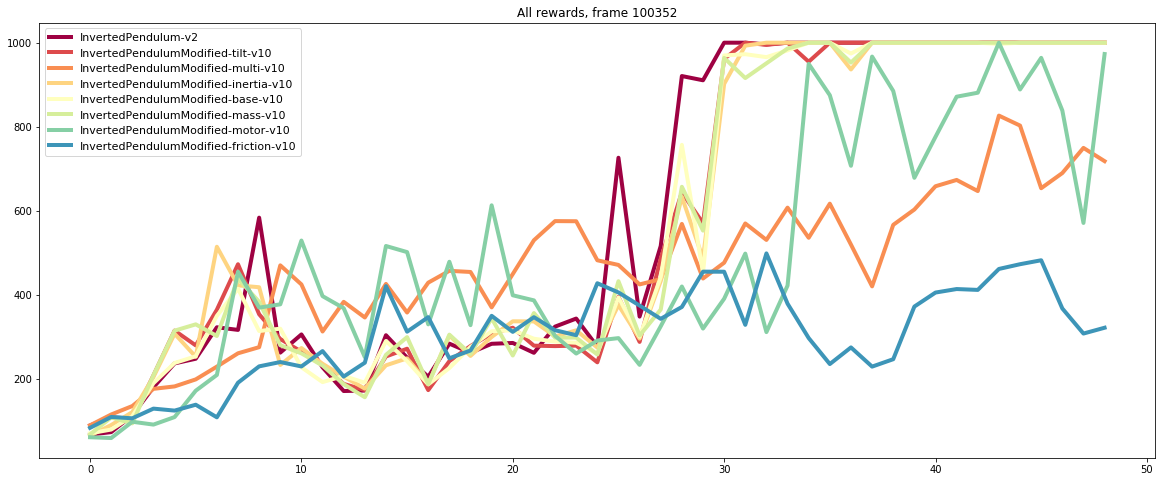

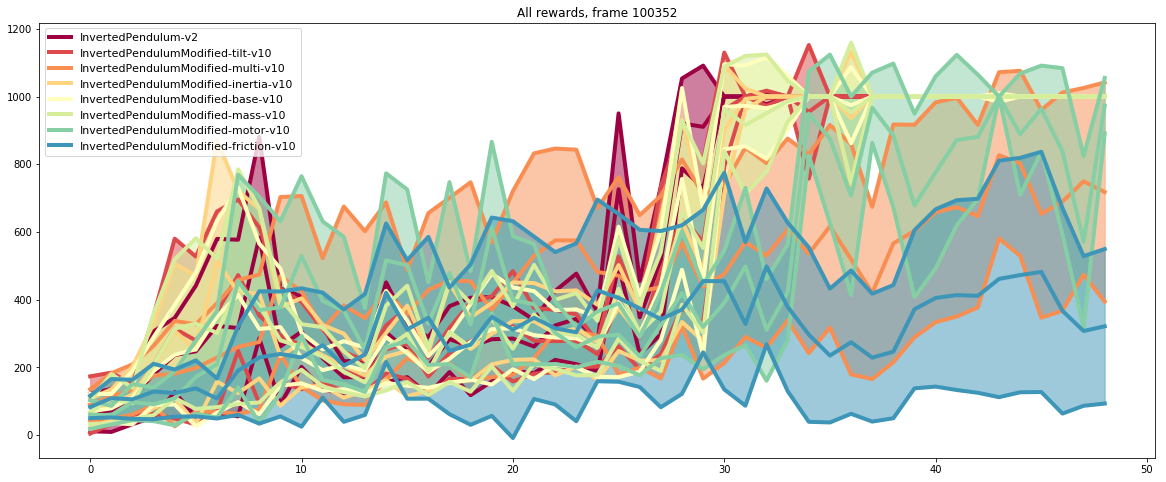

In [13]:
state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

test_avg_rewards = []
test_stds = []

max_frames = 100000
compensator_test = compensator(num_inputs, num_outputs, ppo_baseline)

while compensator_test.ppo_compensator.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = compensator_test.collect_data(envs)
    
    #compute gae
    returns = compensator_test.ppo_compensator.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    compensator_test.ppo_compensator.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, compensator_test) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            ppo_baseline.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

ppo_baseline.save_weights(baseline_dir + env_name + '_compensator_endweights')

## Train compensator with action appended

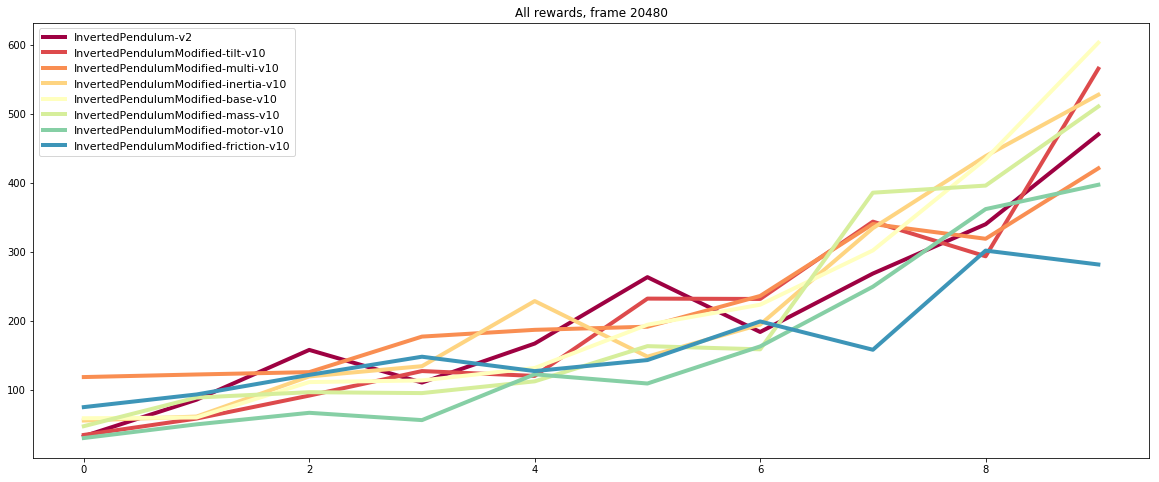

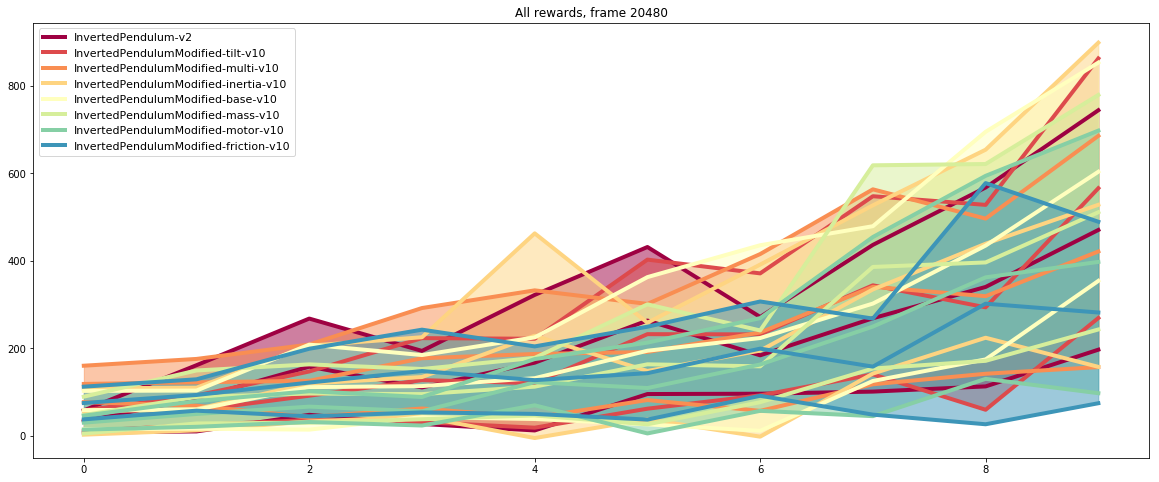

In [ ]:
state = envs.reset()
early_stop = False
ppo_updates = 0
save_interval = 5
#Plotting Flags
indvplots=0
rewplots=1
stdplots=1
which_plts = [indvplots,rewplots,stdplots]

test_avg_rewards = []
test_stds = []

compensator_test = compensator(num_inputs, num_outputs, ppo_baseline, action_appended = True)

while compensator_test.ppo_compensator.frame_idx < max_frames and not early_stop:

    #collect data
    log_probs, values, states, actions, rewards, masks, next_value = compensator_test.collect_data(envs)
    
    #compute gae
    returns = compensator_test.ppo_compensator.compute_gae(next_value, rewards, masks, values)
    
    #update policy
    compensator_test.ppo_compensator.ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, values)
    
    #plot
    avg_rew = []
    std = []
    
    #Environment testing and data logging
    #***************************************************************************************
    for env in tests.envs:
        env_rewards = ([tests.test_env(env, compensator_test) for _ in range(test_itrs)])
        avg_rew.append(np.mean(env_rewards))
        std.append(np.std(env_rewards))

    test_avg_rewards.append(avg_rew)
    test_stds.append(std)

    if avg_rew[training_env_index] > threshold_reward and EARLY_STOPPING: #avg_rew[0] is testing on the non edited environment
        tests.plot(ppo_baseline.frame_idx, test_avg_rewards, test_stds, which_plts, 1)
        early_stop = True
    else:
        if ppo_updates and ppo_updates % save_interval == 0:
            ppo_baseline.save_weights(baseline_dir + env_name + '_weights' + str(ppo_updates/save_interval))
            tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 1, str(ppo_updates/save_interval))
        else:
            tests.plot(compensator_test.ppo_compensator.frame_idx, test_avg_rewards, test_stds, which_plts, 0)
            
    ppo_updates = ppo_updates + 1 #Loop counter
    #***************************************************************************************

ppo_baseline.save_weights(baseline_dir + env_name + '_compensatorAction_endweights')